In [352]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import activations
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from math import *

# 1. Generate Data

(2.16, -21.640000000000015)
102


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


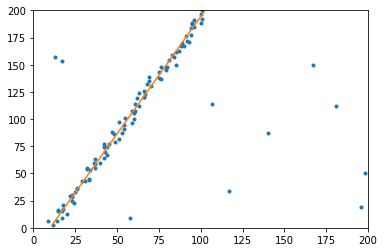

In [353]:
sigma_noise = [2, 2]
image_size = (200, 200)

def generate_line(image):
    a = int(random.uniform(-10, 10) * 100) / 100
    p = (np.random.randint(image[0]), np.random.randint(image[1]))
    b = p[1] - a*p[0]
    return (a, b)

def compute_line_from_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    if (x2-x1) != 0:
        a = int((y2-y1)/(x2-x1) * 100) / 100
    else:
        a = 100
    b = y1 - a*x1
    return (a, b)
    

def generate_data(line, image, sigma, n_inliers=100, n_outliers=10):
    a, b = line
    L_X = []
    L_Y = []
    Points = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            p = np.array([x, y])
            Points.append(p)
    covariance = np.diag(np.array(sigma) ** 2)
    n_i = max(1, n_inliers // len(Points))
    for point in Points:
        sample = np.random.multivariate_normal(point, covariance, n_i)
        sample_X = map(int, sample[:, 0])
        sample_Y = map(int, sample[:, 1])
        L_X.extend(sample_X)
        L_Y.extend(sample_Y)
    
    for k in range(n_outliers):
        (x, y) = (np.random.randint(image[0]), np.random.randint(image[1]))
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)

def plot_data(D, ax):
    L_x, L_y = D
    ax.plot(L_x, L_y, '.')

def plot_line(line, image, ax):
    a, b = line
    X = []
    Y = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            X.append(x)
            Y.append(y)
    ax.plot(X, Y)
    
fig, ax = plt.subplots()
ax.set_xlim(0, image_size[0])
ax.set_ylim(0, image_size[1])
line = generate_line(image_size)
print(line)
D = generate_data(line, image_size, sigma_noise)
plot_data(D, ax)
plot_line(line, image_size, ax)
fig.show()
#print(D)
print(len(D[0]))

### Loss between 2 lines

(5.75, -463.5)
(-5.43, 651.74)
36218
3782
True
area final =  3782


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


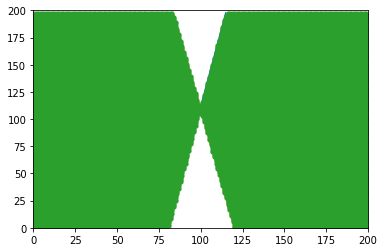

In [354]:
def point_y_in_image(l, x, image_y):
    a, b = l
    y = int(a*x+b)
    y = min(max(y, 0), image_y-1)
    return y

def loss(l1, l2, image):
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
    area2 = image[0]*image[1] - area1
    
    inter = intersect(l1, l2, image)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1
    #print("area final = ", area)
    return area

def intersect(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    if a1 == a2:
        return False
    else:
        x = (b2 - b1)/(a1-a2)
        y = a1*x+b1
        if x >= 0 and x < image[0] and y >= 0 and y < image[1]:
            return True
        else:
            return False

def change_sign(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    d1 = b1 - b2
    x = image[0]
    d2 = (a1*x+b1)-(a2*x+b2)
    if d1*d2 < 0:
        return True
    else:
        return False

def plot_loss(l1, l2, image, ax):
    plot_line(l1, image_size, ax)
    plot_line(l2, image_size, ax)
    area_X = []
    area_Y = []
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
        for k in range(min(y1, y2), max(y1, y2)):
            area_X.append(x)
            area_Y.append(k)
    ax.plot(area_X, area_Y, '.')
    print(area1)
    area2 = image[0]*image[1] - area1
    print(area2)
    
    inter = intersect(l1, l2, image)
    print(inter)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        print(sign)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1
    print("area final = ", area)
    fig.show()

fig, ax = plt.subplots()
ax.set_xlim(0, image_size[0])
ax.set_ylim(0, image_size[1])
line1 = generate_line(image_size)
print(line1)

line2 = generate_line(image_size)
print(line2)
plot_loss(line1, line2, image_size, ax)

### Neural network model

In [355]:
class Network():

    def __init__(self, input_shape, batch_size=32, epochs=5):
        
        self.model_cnn = Sequential()
        self.batch_size = batch_size
        self.epochs=epochs

        self.model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
        self.model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model_cnn.add(Dropout(0,25))
        self.model_cnn.add(Flatten())
        self.model_cnn.add(Dense(128, activation='relu'))
        self.model_cnn.add(Dropout(0.5))
        self.model_cnn.add(Dense(1, activation='relu'))

        self.model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                          optimizer=keras.optimizers.Adadelta(),
                          metrics=['accuracy'])

        self.model_cnn.summary()
        
        
    def train_nn(self, x_train, y_train, x_test, y_test):
        # Run the train
        history = self.model_cnn.fit(x_train, y_train,
                                batch_size=self.batch_size,
                                epochs=self.epochs,
                                verbose=1,
                                validation_data=(x_test, y_test))
        
        score = self.model_cnn.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])


    def predict(x):
        y = self.model_cnn.predict_classes(x)
        return y
    

In [356]:
def compute_features(data, i1, i2):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = (p2[0]-p1[0], p2[1]-p1[0])
    feature = (p1, p2, vec)
    return feature
    

def generate_training_data(image, sigma, nbr, nbr_per_line):
    Lines = []
    Datas = []
    X = []
    Y = []
    for k in range(nbr):
        line_ref = generate_line(image)
        Lines.append(line_ref)
        data = generate_data(line_ref, image, sigma)
        Datas.append(data)
        nbr_points = len(data[0])
        for i in range(int(sqrt(nbr_per_line))):
            i1 = np.random.randint(nbr_points)
            for i in range(int(sqrt(nbr_per_line))):
                i2 = np.random.randint(nbr_points)
                while i2 == i1:
                    i2 = np.random.randint(nbr_points)
                feature=compute_features(data, i1, i2)
                X.append(feature)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2)
                area = loss(line_ref, line, image)
                Y.append(area)
    return (X, Y)

def split_training(xy, prop=0.1):
    (X, Y) = xy
    k = int(prop*len(X))
    x_test = X[:k]
    y_test = Y[:k]
    x_train = X[k:]
    y_train = Y[k:]
    return ((x_test, y_test), (x_train, y_train))

In [362]:
def train_model(image, sigma, nbr, nbr_per_line, batch_size=32, epochs=5):
    ((x_test, y_test), (x_train, y_train)) = split_training(generate_training_data(image, sigma, nbr, nbr_per_line))
    input_shape = (2, 2, 2)
    model = Network(input_shape, batch_size=batch_size, epochs=epochs)
    print("training...", end='')
    model.train_nn(x_train, y_train, x_test, y_test)
    print("done")
    return model




### Compute weights from model

In [363]:
def compute_weights(model, data, i1):
    weights = []
    n = len(data[0])
    
    print(data)
    p1 = data[0][i1], data[1][i1]
    for i2 in range(n):
        if i2==i1:
            weights.append(0)
        else:
            features = compute_features(data, i1, i2)
            p2 = data[0][i2], data[1][i2]
            w = model.predict(features)
            weights.append(w)
    return weights

def sample_from_weights(data, weights, sample, sigma=5):
    n = len(data[0])
    m = 1
    if len(sample) == 0:
        x1 = np.random.randint(n)
        for k in range(1000):
            x2 = int(np.random.normal(loc=x2, scale=sigma))
            alpha = weights[x2]/weights[x1]
            u = random.uniform(0, 1)
            if u <= alpha:
                x1 = x2
    else:
        x1 = sample[-1]
    
    for k in range(m):
        x2 = int(np.random.normal(loc=x2, scale=sigma))
        alpha = weights[x2]/weights[x1]
        u = random.uniform(0, 1)
        if u <= alpha:
            x1 = x2
        sample.append(x1)


### Ransac

In [365]:
def get_inliers(data, line, threshold):
    a, b = line
    X, Y = data
    Inliers = []
    for x in X:
        if abs((a*x+b) - y) < threshold:
            Inliers.append((x, y))
    return Inliers

def get_model(model, data, image, sample):
    n = len(data[0])
    i1 = np.random.randint(n)
    weights = compute_weights(model, data, i1)
    sample_from_weights(data, weights, sample)
    i2 = sample[-1]
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2)
    return line


def update_stopping_criterion(k, inliers, proba):
    if k > 100:
        return true
    return false


def ransac(model, data, threshold, image, proba):
    k = 0
    inliers_max = []
    line_max = None
    end = False
    while not end:
        sample = []
        line = get_model(model, data, image, sample)
        inliers = get_inliers(data, line, threshold)
        if len(inliers) > len(inliers_max):
            inliers_max = inliers
            line_max = line
        k += 1
        end = update_stopping_criterion(k, inliers, proba)
    return line_max

### Full test

In [366]:
def test(image, sigma):
    line = generate_line(image)
    data = generate_data(line, image, sigma)
    
    nbr = 50
    nbr_per_line = 100
    model = train_model(image, sigma, nbr, nbr_per_line)
    
    line_predict = ransac(model, data, 3, image, 0.1)
    
    fig, ax = plt.subplots()
    ax.set_xlim(0, image[0])
    ax.set_ylim(0, image[1])
    plot_data(data, ax)
    plot_line(line, image, ax)
    plot_line(line_predict, image, ax)
    fig.show()
    
    return line_predict

test(image_size, sigma)



ValueError: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_6/convolution' (op: 'Conv2D') with input shapes: [?,2,2,2], [3,3,2,32].